# Lecture 3 : Training a Neural Network

In this lecture, let's review how to train a neural network in details.

## 🍷 Dataset

We are going to consider the Wine dataset that distinguishes 3 different wines depending on 13 different features. In order to see what's going on underneath a tool like pytorch, we are going to now use any tool and implement everything ourself, even the Automatic Differentiation. Let's first activate the environment and make sure we have installed all the dependencies listed in the environment.

In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `~/git/UCLouvain/linma2472-private/Lecture3`


If not already done, install the packages required by the environment.

In [ ]:
Pkg.instantiate()

The Wine dataset has 13 features. We import it directly as matrix and not as dataframe (hence the option `as_df = false`).

In [2]:
import MLDatasets, DataFrames
wine = MLDatasets.Wine(; as_df = false)

dataset Wine:
  metadata   =>    Dict{String, Any} with 4 entries
  features   =>    13×178 Matrix{Float64}
  targets    =>    1×178 Matrix{Int64}
  dataframe  =>    nothing

We normalise each feature by shifting by its mean and dividing it by its standard deviation.
We also convert to 32-bit floating point numbers.
Even if the computer is 64-bit. Using 32-bit precision allows to decrease the required memory for the data and model by 2.
GPUs also uses 32-bit floating point numbers so they will be faster with 32-bit.

In [3]:
import Statistics
function normalise(x)
  μ = Statistics.mean(x, dims=2)
  σ = Statistics.std(x, dims=2, mean=μ)
  return (x .- μ) ./ σ
end
X = Float32.(normalise(wine.features))

13×178 Matrix{Float32}:
  1.51434    0.245597   0.196325   …   0.331822   0.208643    1.39116
 -0.560668  -0.498009   0.0211715      1.73984    0.227053    1.57871
  0.2314    -0.825667   1.10621       -0.38826    0.0126963   1.36137
 -1.1663    -2.48384   -0.267982       0.151234   0.151234    1.49872
  1.90852    0.018094   0.0881098      1.41841    1.41841    -0.261969
  0.806722   0.567048   0.806722   …  -1.12665   -1.03078    -0.391646
  1.03191    0.731565   1.21211       -1.3408    -1.35081    -1.27072
 -0.657708  -0.818411  -0.497005       0.547563   1.35108     1.59213
  1.22144   -0.543189   2.12996       -0.420888  -0.228701   -0.420888
  0.251009  -0.292496   0.268263       2.21798    1.82976     1.78663
  0.361158   0.404908   0.317409   …  -1.60759   -1.56384    -1.52009
  1.84272    1.11032    0.786369      -1.48127   -1.39676    -1.42493
  1.01016    0.962526   1.39122        0.279786   0.295664   -0.593486

We convert the output to 32-bit. We could use one-hot encoding here but let's keep it simple.

In [4]:
y = Float32.(wine.targets) .- 2

1×178 Matrix{Float32}:
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0

## ⚗️ Model

Let's use 1 hidden layer with 32 `tanh` activation functions.

In [5]:
function init(dims...)
    (rand(Float32, dims...) .- Float32(0.5)) # .* sqrt(24.0f0 / (num_rows + num_cols))
end
h = 32
model = [init(h, size(X, 1)), init(size(y, 1), h)]

function estimate(model, X)
    W1, W2 = model
    return W2 * tanh.(W1 * X)
end

estimate(model, X)

1×178 Matrix{Float32}:
 -0.00406254  1.40675  0.010882  0.557059  …  0.729964  0.594918  -0.607687

The loss is computed using Mean Squared Errors (MSE).

In [6]:
function loss(model, X, y)
    sum((estimate(model, X) .- y).^2) / size(X, 2)
end
loss(model, X, y)

1.6410899f0

## ⚒️ Automatic Differentiation

### Forward Differentiation

Forward differentiation can be implemented with operator overloading using the chain rule. This allows differentiating arbitrary code.

In [7]:
struct Dual{T}
    value::T
    derivative::T
end
Dual(x, y) = Dual{typeof(x)}(x, convert(typeof(x), y))

# By linearity of the derivative
Base.:*(α::T, x::Dual{T}) where {T} = Dual(α * x.value, α * x.derivative)
Base.:*(x::Dual{T}, α::T) where {T} = Dual(x.value * α, x.derivative * α)
Base.:+(x::Dual{T}, y::Dual{T}) where {T} = Dual(x.value + y.value, x.derivative + y.derivative)
Base.:-(x::Dual{T}, y::T) where {T} = Dual(x.value - y, x.derivative)
Base.:/(x::Dual, α::Number) = Dual(x.value / α, x.derivative / α)

# The product rule
Base.:*(x::Dual{T}, y::Dual{T}) where {T} = Dual(x.value * y.value, x.value * y.derivative + x.derivative * y.value)
Base.:^(x::Dual, n::Integer) = Base.power_by_squaring(x, n)

# Used to initialize accumulator in Matrix-Matrix product
Base.zero(::Dual{T}) where {T} = Dual(zero(T), zero(T))

# tanh(x)' = (1 - tanh(x)^2) * x'
function Base.tanh(x::Dual)
    y = tanh(x.value)
    return Dual(y, (1 - y^2) * x.derivative)
end

We need to compute the derivative with respect to each weight separately. To compute the derivative with respect to `model[i][j, k]`, we use a dual number `Dual(model[i][j, k], 1)` for that weight and `Dual(model[i'][j', k'], 0)` for the other weights.

In [8]:
function ∇model(f, model, X, y, ∇i, ∇j, ∇k)
    Δmodel = [
        [ifelse((i, j, k) == (∇i, ∇j, ∇k), Dual(model[i][j, k], 1), Dual(model[i][j, k], 0)) for j in axes(model[i], 1), k in axes(model[i], 2)]
        for i in eachindex(model)
    ]
    l = f(Δmodel, X, y)
    return l.derivative
end

function ∇model(f, model, X, y, ∇i)
    W = model[∇i]
    return [∇model(f, model, X, y, ∇i, ∇j, ∇k) for ∇j in axes(W, 1), ∇k in axes(W, 2)]
end

function ∇model(f, model, X, y)
    return [∇model(f, model, X, y, ∇i) for ∇i in eachindex(model)]
end

∇model(loss, model, X, y)

2-element Vector{Matrix{Float32}}:
 [-0.1051119 0.09428666 … -0.12797613 -0.18713857; -0.07611398 0.10896457 … -0.097582884 -0.18083568; … ; -0.23783705 0.07540423 … -0.15654108 -0.3620776; -0.31050986 0.20585349 … -0.29831308 -0.5073731]
 [-0.91347224 -1.4262512 … -0.46793005 0.55736864]

Run the following cell to restart with a new random model and reset the Adam optimiser accordingly.

In [9]:
model = [init(h, size(X, 1)), init(size(y, 1), h)]
losses = [loss(model, X, y)]
import Optimisers
opt = Optimisers.Adam()
states = [Optimisers.init(opt, W) for W in model]

2-element Vector{Tuple{Matrix{Float32}, Matrix{Float32}, Tuple{Float32, Float32}}}:
 ([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))
 ([0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0], (0.9, 0.999))

The following cell runs 100 iterations using the whole dataset for each iteration.

In [10]:
@time for epoch in 1:100
    grads = ∇model(loss, model, X, y)
    # Gradient descent with rate `η`
    for i in eachindex(model)
        states[i], ΔW = Optimisers.apply!(opt, states[i], model[i], grads[i])
        model[i] .-= ΔW
    end
    push!(losses, loss(model, X, y))
end
losses

  3.027570 seconds (1.71 M allocations: 6.562 GiB, 3.65% gc time, 7.81% compilation time)


101-element Vector{Float32}:
 1.9197679
 1.8126762
 1.7100246
 1.6118748
 1.518269
 1.4292357
 1.3447908
 1.2649319
 1.1896353
 1.1188571
 1.0525328
 0.99057823
 0.93288875
 ⋮
 0.14479968
 0.14334036
 0.14191763
 0.14053017
 0.13917674
 0.13785622
 0.13656749
 0.13530962
 0.13408166
 0.13288279
 0.1317121
 0.13056883

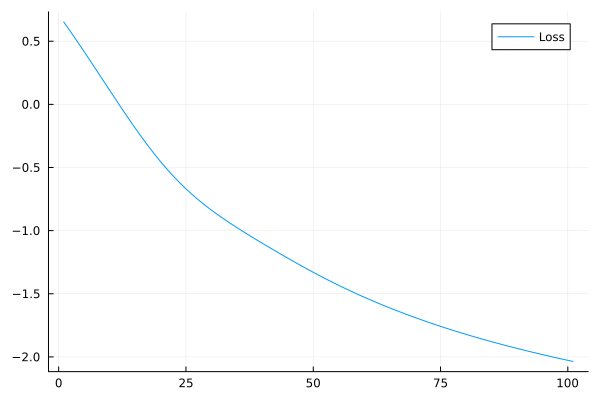

In [11]:
using Plots
plot(eachindex(losses), log.(losses), label = "Loss")

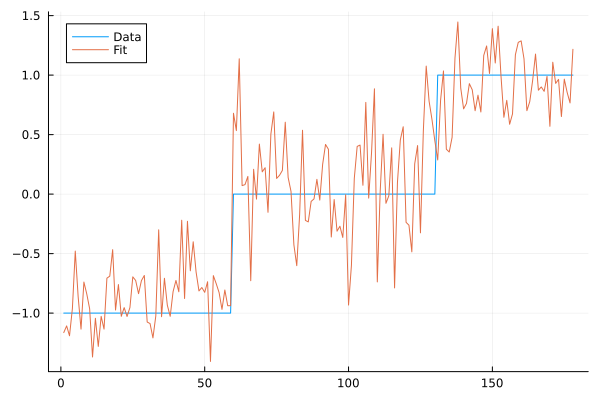

In [12]:
plot(axes(y, 2), y[:], label = "Data")
plot!(axes(y, 2), estimate(model, X)[:], label = "Fit")

In [13]:
using OneHotArrays
function jacobians(model, X, y)
    y_1 = tanh.(model[1] * X)
    jac_tanh = 1 .- y_1.^2
    jac_mse = 2 * (model[2] * y_1 - y) / size(y, 2)
    return jac_tanh, jac_mse
end
function jacobian_combine(model, X, y, j, k)
    ∂W_1 = onehot(j, axes(model[1], 1)) * onehot(k, axes(model[1], 2))'
    J_1, J_2 = jacobians(model, X, y)
    (model[2] * (J_1 .* (∂W_1 * X))) * J_2'
end
jacobian_combine(model, X, y, 1, 1)

1×1 Matrix{Float32}:
 -0.016746128

In [14]:
∇model(loss, model, X, y, 1, 1, 1)

-0.016746132f0

### ~~Backward~~ Reverse Differentiation

Viewing this as a product of Jacobian matrices, linear algebra will allow us to find a faster way to compute the gradient. This is will introduce *reverse differentiation*.

The broadcasted `*` is an Hadamard product, denoted $\odot$. So what we compute in `jacobian_combine` is:
$$
W_2 (J_1 \odot (\partial W_1 X)) J_2^\top
$$
As this is scalar, it is trivially equal to its scalar product with ``1``. We can then move everything to the right-hand side with the adjoint (here, it is the transpose):
$$
\begin{align}
\langle W_2 (J_1 \odot (\partial W_1 X)) J_2^\top, 1 \rangle
& =
\langle J_1 \odot (\partial W_1 X), W_2^\top J_2 \rangle\\
& =
\langle \partial W_1 X, J_1 \odot (W_2^\top J_2) \rangle\\
& =
\langle \partial W_1 X, J_1 \odot (W_2^\top J_2) \rangle\\
& =
\langle \partial W_1, (J_1 \odot (W_2^\top J_2))X^\top \rangle\\
\end{align}
$$
Now, for the derivative with respect to the entry $W_{i,j}$, we use $\partial W_1 = e_ie_j^\top$ and
$$
\langle e_ie_j^\top, (J_1 \odot (W_2^\top J_2))X^\top \rangle
=
((J_1 \odot (W_2^\top J_2))X^\top)_{ij}
$$
So the gradient with respect to $W_1$ is exactly the matrix $(J_1 \odot (W_2^\top J_2))X^\top$ !

In [15]:
function jacobian_adjoint(model, X, y)
    J_1, J_2 = jacobians(model, X, y)
    (J_1 .* (model[2]' * J_2)) * X'
end
jacobian_adjoint(model, X, y)

32×13 Matrix{Float32}:
 -0.0167461   -0.00719482    0.0195071    …  -0.00201555   0.014193
 -0.00704094   0.00656176    0.014611        -0.0121835    0.0092237
  0.0109434   -0.00706819   -0.0078698        0.0204852   -0.00515536
  0.0118795   -0.0143569    -0.0104847        0.0130499   -0.00542107
  0.00816466  -0.00443311   -0.0233895        0.0148583   -0.00782927
 -0.00452165   0.00639268    0.00736856   …  -0.00949257   0.00411564
  0.00929972  -0.00552386   -0.00479368       0.0135718   -0.00272814
  0.0151182   -0.00110865   -0.000980799      0.0141343   -0.00220155
  0.0145859   -0.00547757   -0.00293678       0.0108184   -0.0017021
  0.00674886  -0.0150045    -0.0139963        0.0222901   -0.00856839
 -0.00818229   0.00339582    0.0160015    …  -0.0113117    0.00560697
 -0.00728608   0.00463509    0.0206062       -0.0143144    0.0119917
 -0.0240161    0.00734717   -0.00715775      -0.0167572    0.00311585
  ⋮                                       ⋱               
  0.0130642  

In [16]:
∇model(loss, model, X, y, 1) ≈ jacobian_adjoint(model, X, y)

true

We can do the same to compute the derivative with respect to $W_2$.
Forward diff computes $\partial W_2\tanh(W_1 X) J_2^\top$ ($\tanh$ being applied elementwise) so let's see what the adjoint trick gives us for the reverse diff:
$$
\begin{align}
\langle \partial W_2\tanh(W_1 X) J_2^\top, 1 \rangle
& =
\langle \partial W_2, J_2 \tanh(W_1 X)^\top \rangle
\end{align}
$$
So the reverse diff computation for the gradient with respect to $W_2$ is $J_2 \tanh(W_1 X)^\top$.

In [17]:
function ∇loss_reverse(model, X, y)
    y_1 = tanh.(model[1] * X)
    jac_tanh = 1 .- y_1.^2
    jac_mse = 2 * (model[2] * y_1 - y) / size(y, 2)
    ∇W1 = (jac_tanh .* (model[2]' * jac_mse)) * X'
    ∇W2 = jac_mse * y_1'
    return [∇W1, ∇W2]
end
∇loss_reverse(model, X, y) ≈ ∇model(loss, model, X, y)

true

Using reverse diff instead of forward diff gives us a 200x speedup, not bad!

In [29]:
function train_reverse_diff!(losses, model, X, y, opt, num_iters, states)
    @time for epoch in 1:num_iters
        grads = ∇loss_reverse(model, X, y)
        # Gradient descent with rate `η`
        for i in eachindex(model)
            states[i], ΔW = Optimisers.apply!(opt, states[i], model[i], grads[i])
            model[i] .-= ΔW
        end
        push!(losses, loss(model, X, y))
    end
end

train_reverse_diff! (generic function with 2 methods)

In [19]:
train_reverse_diff!(losses, model, X, y, opt, 1000, states)
losses

  0.089307 seconds (27.00 k allocations: 159.098 MiB, 16.73% gc time)


1101-element Vector{Float32}:
 1.9197679
 1.8126762
 1.7100246
 1.6118748
 1.518269
 1.4292357
 1.3447908
 1.2649319
 1.1896353
 1.1188571
 1.0525328
 0.99057823
 0.93288875
 ⋮
 0.01766273
 0.017647097
 0.017631482
 0.017615901
 0.017600333
 0.017584793
 0.017569272
 0.017553777
 0.017538298
 0.017522838
 0.017507408
 0.017492006

### When should forward differentiation be used ?

Suppose that we need to differentiate a composition of functions:
$(f_n \circ f_{n-1} \circ \cdots \circ f_2 \circ f_1)(w)$.
For each function, we can compute a jacobian given the value of its input.
So, during a forward pass, we can compute all jacobians. We now just need to take the product of these jacobians:
$$J_n J_{n-1} \cdots J_2 J_1$$
While the product of matrices is associative, its computational complexity depends on the order of the multiplications!
Let $d_i \times d_{i - 1}$ be the dimension of $J_i$.

#### Forward diff: from right to left

If the product is computed from right to left:
$$
\begin{align}
  J_{1,2} & = J_2 J_1 && \Omega(d_2d_1d_0)\\
  J_{1,3} & = J_3 J_{1,2} && \Omega(d_3d_2d_0)\\
  J_{1,4} & = J_4 J_{1,3} && \Omega(d_4d_3d_0)\\
  \vdots & \quad \vdots\\
  J_{1,n} & = J_n J_{1,(n-1)} && \Omega(d_nd_{n-1}d_0)\\
\end{align}
$$
we have a complexity of
$$\Omega(\sum_{i=2}^n d_id_{i-1}d_0).$$

#### Reverse diff: from left to right

The adjoint trick gives
$$\langle J_n J_{n-1} \cdots J_2 J_1 \partial w, \partial y \rangle
=
\langle \partial w, J_1^\top J_2^\top \cdots J_{n-1}^\top J_n^\top \partial y \rangle.$$
So reverse differentation corresponds to multiplying the adjoint from right to left or equivalently the original matrices from left to right.
This means computing the product in the following order:
$$
\begin{align}
  J_{(n-1),n} & = J_n J_{n-1} && \Omega(d_nd_{n-1}d_{n-2})\\
  J_{(n-2),n} & = J_{(n-1),n} J_{n-2} && \Omega(d_nd_{n-2}d_{n-3})\\
  J_{(n-3),n} & = J_{(n-2),n} J_{n-3} && \Omega(d_nd_{n-3}d_{n-4})\\
  \vdots & \quad \vdots\\
  J_{1,n} & = J_{2,n} J_1 && \Omega(d_nd_1d_0)\\
\end{align}
$$
We have a complexity of
$$\Omega(\sum_{i=1}^{n-1} d_nd_id_{i-1}).$$

#### Mixed : from inward to outward

We can also write
$$\langle J_n J_{n-1} \cdots J_2 J_1 \partial w, \partial y \rangle
=
\langle J_k J_{k-1} \cdots J_2 J_1\partial w, J_{k+1}^\top J_{k+2}^\top \cdots J_{n-1}^\top J_n^\top \partial y \rangle.$$
This corresponds to multiplying starting from some $d_k$ where $1 < k < n$.
We would then first compute the left side:
$$
\begin{align}
  J_{k+1,k+2} & = J_{k+2} J_{k+1} && \Omega(d_{k+2}d_{k+1}d_{k})\\
  J_{k+1,k+3} & = J_{k+3} J_{k+1,k+2} && \Omega(d_{k+3}d_{k+2}d_{k})\\
  \vdots & \quad \vdots\\
  J_{k+1,n} & = J_{n} J_{k+1,n-1} && \Omega(d_nd_{n-1}d_k)
\end{align}
$$
then the right side:
$$
\begin{align}
  J_{k-1,k} & = J_k J_{k-1} && \Omega(d_kd_{k-1}d_{k-2})\\
  J_{k-2,k} & = J_{k-1,k} J_{k-2} && \Omega(d_kd_{k-2}d_{k-3})\\
  \vdots & \quad \vdots\\
  J_{1,k} & = J_{2,k} J_1 && \Omega(d_kd_1d_0)\\
\end{align}
$$
and then combine both sides:
$$J_{1,n} = J_{k+1,n} J_{1,k} \qquad \Omega(d_nd_kd_0)$$
we have a complexity of
$$\Omega(d_nd_kd_0 + \sum_{i=1}^{k-1} d_kd_id_{i-1} + \sum_{i=k}^{n} d_id_{i-1}d_k).$$

#### Comparison

We see that we should find the minimum $d_k$ and start from there. If the minimum is attained at $k = n$, this corresponds mutliplying from left to right, this is reverse differentiation. If the minimum is attained at $k = 0$, we should multiply from right to left, this is forward differentiation. Otherwise, we should start from the middle, this would mean mixing both forward and reverse diff.

What about neural networks ? In that case, $d_0$ is equal to the number of entries in $W_1$ added with the number of entries in $W_2$ while $d_n$ is $1$ since the loss is scalar. We should therefore clearly multiply from left to right hence do reverse diff.

## ⚙️ Computation on the GPU

We are going to define a `gpu` function that sends an array to the GPU. This depends on which GPU you have

### For intel, run this

In [20]:
import oneAPI
oneAPI.versioninfo()

Binary dependencies:
- NEO: 24.22.29735+0
- libigc: 1.0.16695+0
- gmmlib: 22.3.19+0
- SPIRV_LLVM_Translator_unified: 0.4.0+0
- SPIRV_Tools: 2024.2.0+0

Toolchain:
- Julia: 1.10.5
- LLVM: 15.0.7

1 driver:
- 00000000-0000-0000-17fa-88a2010371d2 (v1.3.29138, API v1.3.0)

1 device:
- Intel(R) Iris(R) Xe Graphics


In [21]:
gpu = oneAPI.oneArray

oneAPI.oneArray

### For nvidia, run this

In [22]:
run(`nvidia-smi`)

LoadError: IOError: could not spawn `nvidia-smi`: no such file or directory (ENOENT)

In [23]:
import CUDA
CUDA.functional(true)

LoadError: CUDA driver not found

In [24]:
CUDA.versioninfo()

LoadError: CUDA driver not found

In [25]:
gpu = CUDA.cu

cu (generic function with 1 method)

### Back to GPU-agnostic

In [22]:
function train_reverse_diff!(losses, model, X, y, opt, num_iters)
    states = [Optimisers.init(opt, W) for W in model]
    train_reverse_diff!(losses, model, X, y, opt, num_iters, states)
end

train_reverse_diff! (generic function with 2 methods)

In [23]:
gpu(y)

1×178 oneAPI.oneArray{Float32, 2, oneAPI.oneL0.DeviceBuffer}:
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [ ]:
train_reverse_diff!(losses, gpu.(model), gpu(X), gpu(y), opt, 1)

## What about global minima ?

### ReLU activation function

There are local minima that are not global. Consider 1 hidden layer and $W_1$ such that all inputs to activation are strictly negative. Then the model output is locally zero so a local minimum.

### Identity activation function

With 1 hidden layer, all second-order critical points (SOCPs) (zero gradient and positive semidefinite hessian) are global minima.
With 2 hidden layers or more, some SOCPs are not global minima. For instance, the following is a SOCP:
$$W_1 = \begin{bmatrix}1 & 0\end{bmatrix}, W_2 = \begin{bmatrix}0\end{bmatrix}, W_3 = \begin{bmatrix}1\\0\end{bmatrix}, X = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, Y = \begin{bmatrix}0 & 0\\0 & 1\end{bmatrix}$$
However, this is not a local minimum.
All local minima are global minima for any number of layers.